In [51]:
from statistics import correlation

import kagglehub

# Download latest version
path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")

print("Path to dataset files:", path)

Path to dataset files: /Users/ymlin/.cache/kagglehub/datasets/dylanjcastillo/7k-books-with-metadata/versions/3


In [52]:
import pandas as pd

In [77]:
books = pd.read_csv(f"{path}/books.csv")

In [ ]:
books
# pycharm give us very useful tools for data exploration, like displaying dataframes, plotting, etc.

It is important to find whether the missing values are linked to specific patterns. -> create a missingness heatmap using seaborn.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = plt.axes()
sns.heatmap(books.isna().transpose(), cbar=False, ax=ax)

plt.xlabel("Columns")
plt.ylabel("Missing Values")
plt.show()

# ## Missingness overview
#
# A visual missingness map is plotted above to locate columns with many missing values. This helps form hypotheses about whether missing data is random or linked to book metadata (age, category, etc.).
#
# Initial observations (from the heatmap)
# - `subtitle` appears to be mostly missing.
# - `categories`, `thumbnail`, and `description` show sporadic missingness.
#
# Action: follow-up analyses quantify missing fractions and test if missingness correlates with other features.

In [80]:
# Check patterns for specific important columns (example: 'description')
# we guess that the books without description might older or shorter books

import numpy as np

books["missing_description"] = np.where(books["description"].isna(), 1, 0)
books["age_of_book"] = 2025 - books["published_year"]

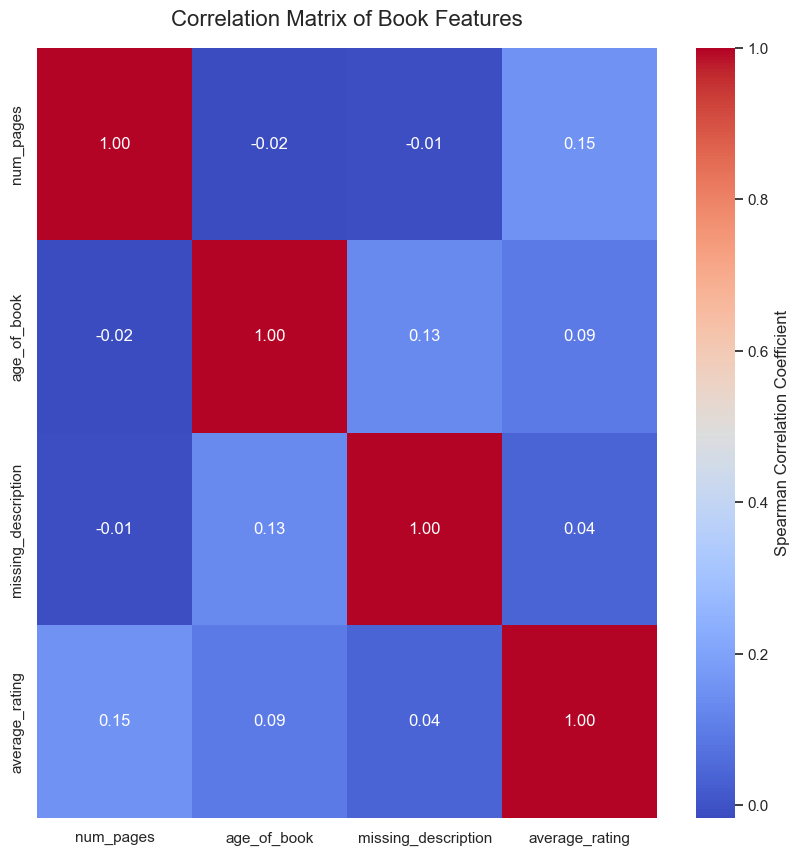

In [81]:
columns_of_interest = ['num_pages', 'age_of_book', 'missing_description', 'average_rating']
correlation_matrix = books[columns_of_interest].corr(method="spearman") # spearman to capture non-linear relationships

sns.set_theme(style="white")
plt.figure(figsize = (10,10))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Spearman Correlation Coefficient"})
heatmap.set_title("Correlation Matrix of Book Features", fontdict={"fontsize":16}, pad=16)
plt.show()
#
# We computed Spearman correlations among a few derived and numeric features to check whether missing descriptions are associated with short books, older books, or low-rated books.
#
# Key finding
# - No strong correlation was found between `missing_description` and the numerical features checked (num_pages, age_of_book, average_rating). This suggests missing descriptions are not driven by a single obvious numeric factor.
#
# We then examine co-occurrence of missingness across columns to detect structural patterns (e.g., rows missing both `thumbnail` and `description`).

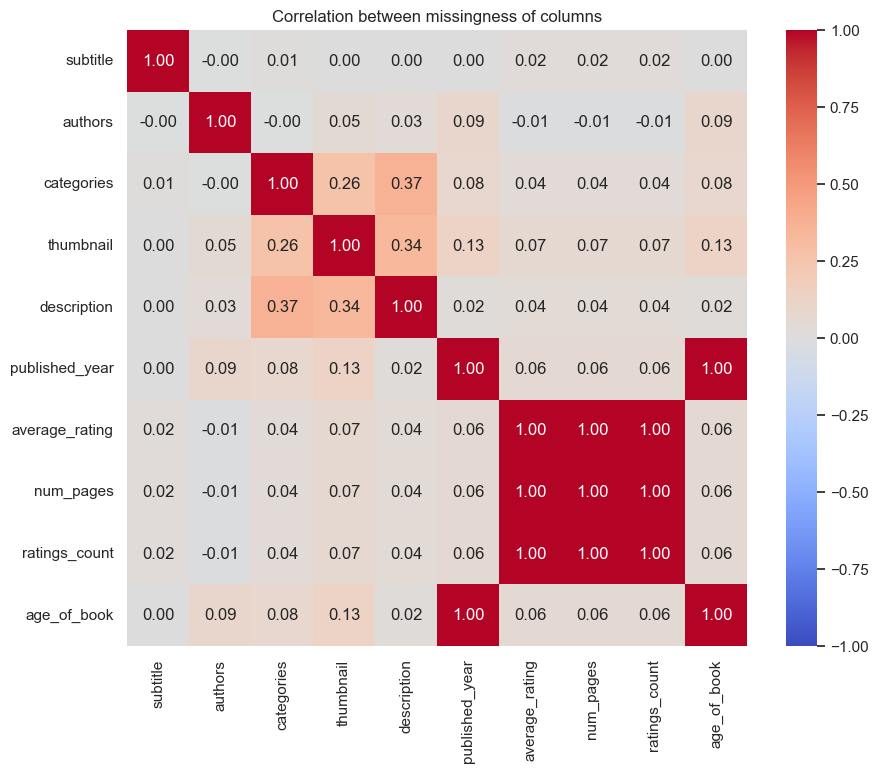

In [82]:
# Correlation between missingness of columns (co-occurrence of missingness)
missing_matrix = books.isna().astype(int)
# Only keep columns that have at least one missing value to make the correlation plot readable
cols_with_missing = missing_matrix.columns[missing_matrix.sum() > 0]
if len(cols_with_missing) >= 2:
    corr = missing_matrix[cols_with_missing].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation between missingness of columns')
    plt.show()
else:
    print('\nNot enough columns with missing values to compute missingness correlation.')

# %% [markdown]
# ### Critical missing fields and removal decision
#
# We identified these fields as critical for downstream tasks: `description`, `num_pages`, `average_rating`, and `published_year`.
#
# - Rows missing any of these fields were counted and inspected.
# - The count of rows with missing values in these critical columns was small (~303 / ~7000 ≈ 4.3%).
#
# Decision
# - Drop rows missing any of the critical fields to prioritize label/feature quality for initial modelling. The percentage removed is small and improves reliability for subsequent steps.

In [84]:
# check how many books have missing in description, num_pages, average_rating, and published_year

cols = ["description", "num_pages", "average_rating", "published_year"]
books_missing = books[books[cols].isna().any(axis=1)]


# the records with missing values is 303/7000 ~ 4.3%, so it's okay that we directly get rid of them

In [ ]:
books = books[~books[cols].isna().any(axis=1)]
books
# %% [markdown]
# ## Category distribution
#
# There are 500+ distinct `categories` in the raw data and the distribution is highly skewed: a small number of categories (notably `Fiction`) contain a large fraction of the dataset while many categories have very few examples.
#
# Implication for modelling
# - We'll need to group or restrict categories (top-K / merge low-frequency categories) or use a multi-label approach depending on the modelling objective.

In [ ]:
books['categories'].value_counts().reset_index().sort_values('count', ascending=False) # count and sort by count in descending order, it will give us the most common categories

# and we can see that we have a very uneven distribution of categories. The most popular category is "Fiction" with over 2000 books, and the other top 10 are around 100 - 200 books. The remaining categories have very few books.
# %% [markdown]
# ## Description-length analysis
#
# We want to ensure descriptions used for text-based features are sufficiently informative. We compute a simple word-count for each description and inspect short vs. long descriptions.
#
# Procedure
# - Compute `length_of_description` as word count.
# - Inspect samples across several length ranges to understand what content short descriptions contain.
#
# Decision
# - Use a conservative cutoff of **25 words** to keep descriptions that are likely to be informative for embedding/feature extraction. This cutoff is empirical and can be tuned later.

In [87]:
# we interest in the words count
books["length_of_description"] = books["description"].str.split().str.len() # str.strip() to remove leading/trailing spaces, str.split() to split by whitespace, str.len() to count the number of words, str.len() works on list to give the length of the list
books # visulaize in histogram

/var/folders/dr/fmvgs2pd0sv_5207d34sb0080000gn/T/ipykernel_3276/3773885143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books["length_of_description"] = books["description"].str.split().str.len() # str.strip() to remove leading/trailing spaces, str.split() to split by whitespace, str.len() to count the number of words, str.len() works on list to give the length of the list


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,length_of_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,43.0,14
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,23.0,63
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,22.0,117
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,26.0,174
6808,9789027712059,9027712050,The Berlin Phenomenology,NaN,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0,0,44.0,245


In [88]:
# check the descriptions those are very short
books.loc[books["length_of_description"].between(1, 4), 'description'] # the first variable is the condition, the second is the column we want to display

6                                           Donation.
11                                     Fantasy-roman.
748              Includes bibliographical references.
770                             Bound For Oregon (PB)
775                                No Marketing Blurb
812                                No Marketing Blurb
857                          First published in 1813.
944                         Edited by Maurice Hindle.
953                        DEFOE/ROBINSON CRUSOE (BC)
954                             Edited by John Carey.
962                         ALLEN/GETTING THINGS DONE
1054                            GILBERT/EAT PRAY LOVE
1056    "Graham Greene centennial, 1904-2004"--Cover.
1060                   STEINBECK/GRAPES OF WRATH (BC)
1346                                   Fantasy-roman.
1546                                      Winter 2003
1610                                      Winter 1999
1813                             National bestseller.
1981                        

In [89]:
# check the descriptions those are very short
books.loc[books["length_of_description"].between(5, 14), 'description'] # the first variable is the condition, the second is the column we want to display

2       Volume Two of Stephen Donaldson's acclaimed se...
38      Koko is Peter Straub's foray into the psycholo...
70      A matter of life and death - and the Throne of...
77                         Nonsense rhyming story. 4 yrs+
84      A study guide for the novel There's a Boy in t...
                              ...                        
6715    The first comprehensive guide to addressing Na...
6726       Presents two complete novels from Henry James.
6757                          Audio Book- unabriged on CD
6776    Raymond Chandler meets The Exorcist. Classic n...
6795    Book Of Five Rings is a Kodansha International...
Name: description, Length: 308, dtype: object

In [90]:
# check the descriptions those are very short
books.loc[books["length_of_description"].between(15, 24), 'description'] # the first variable is the condition, the second is the column we want to display

10      One of Sidney Sheldon's most popular and bests...
32      Tells the story of three generations of Chines...
36      A magical and fantastic collection of early st...
57      A young drifter finds more than he bargained f...
68      A new 'The Doors of Perception' for the 21st c...
                              ...                        
6767    Everything from the fingerprints of the gods t...
6782    Displays one of America's leading physicist's ...
6783    Basics Illustration 01: Thinking Visually expl...
6789    Provides an introduction to the American artis...
6809    This is a jubilant and rewarding collection of...
Name: description, Length: 947, dtype: object

In [91]:
# check the descriptions those are very short
books.loc[books["length_of_description"].between(25, 34), 'description'] # the first variable is the condition, the second is the column we want to display

# here, we finally got some meaningful descriptions

9       Kate Blackwell is an enigma and one of the mos...
14      Available in the U.S. for the first time, this...
20      It is 1937, and Charles Ashworth, a Canon to t...
21      Reissue of the author's most famous and well-l...
46      No one believes a little girl when she insists...
                              ...                        
6760    Joel, an English teacher, has never really lik...
6766    Discusses the historical and intellectual back...
6775    Presents nearly one thousand recipes--from app...
6779    Edited by the creator and executive producer o...
6799    This book is the story of a young girl obsesse...
Name: description, Length: 1229, dtype: object

In [ ]:
# we will use the length of 25 as the cutoff
books_25_description = books[books["length_of_description"] >= 25]
books_25_description
# %% [markdown]
# ## Handling `subtitle` and merging with `title`
#
# Options considered
# - Keep `subtitle` as a separate field (many missing values)
# - Fill missing `subtitle` with empty string or placeholder
# - Merge `title` + `subtitle` into `title_and_subtitle` for a single display field
#
# Action taken
# - Merged `title` and `subtitle` into `title_and_subtitle`, using an empty string when `subtitle` is missing. This keeps titles readable and avoids a separate sparse column.

In [93]:
books_25_description['title_and_subtitle'] = (
    np.where(
        books_25_description['subtitle'].isna(), books_25_description['title'],
        books_25_description['title'] + ': ' + books_25_description['subtitle'])
)
books_25_description

/var/folders/dr/fmvgs2pd0sv_5207d34sb0080000gn/T/ipykernel_3276/3699426170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_25_description['title_and_subtitle'] = (


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,length_of_description,title_and_subtitle
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199,Gilead
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205,Spider's Web: A Novel
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57,Rage of angels
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45,The Four Loves
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0,75,The Problem of Pain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,0,22.0,288,Mistaken Identity
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,23.0,63,Journey to the East
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,22.0,117,The Monk Who Sold His Ferrari: A Fable About F...
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,26.0,174,I Am that: Talks with Sri Nisargadatta Maharaj


In [96]:
# merge the isbn13 to the description for better identification
books_25_description['description_with_id'] = books_25_description[['isbn13', 'description']].astype(str).agg(" ".join, axis=1)
books_25_description

/var/folders/dr/fmvgs2pd0sv_5207d34sb0080000gn/T/ipykernel_3276/974376364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_25_description['description_with_id'] = books_25_description[['isbn13', 'description']].astype(str).agg(" ".join, axis=1)


,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,length_of_description,title_and_subtitle,description_with_id
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45,The Four Loves,9780006280897 Lewis' work on the nature of lov...
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0,75,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,0,22.0,288,Mistaken Identity,9788172235222 On A Train Journey Home To North...
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,23.0,63,Journey to the East,9788173031014 This book tells the tale of a ma...
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,22.0,117,The Monk Who Sold His Ferrari: A Fable About F...,9788179921623 Wisdom to Create a Life of Passi...
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,26.0,174,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...


In [97]:
# save the cleaned dataset
(
    books_25_description
    .drop(columns=['subtitle', 'missing_description', 'age_of_book', 'length_of_description'], axis=1 ) # the axis means we are dropping columns
    .to_csv("books_cleaned.csv", index=False)
)